In [42]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models

In [43]:
use_google_colab = False

if use_google_colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_project = '/content/drive/MyDrive/School/1. University/Year 4/Semester 2/APS360 - Applied Fundamentals of Deep Learning/Project/'
else:
    # When using on local machine. Folder 'split_data' must be in the same dir as this file.
    path_to_project=""
    
print(path_to_project)

In [44]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [45]:
def count_images_and_percentage_with_partition(root):
    partitions = ['train', 'val', 'test']
    classes = ['Glass', 'Metal', 'Paper', 'Plastic']
    total_images = 0
    partition_totals = {}
    counts = {}

    # Count the images in each partition and class
    for partition in partitions:
        partition_counts = {}
        partition_total = 0
        for class_name in classes:
            class_path = os.path.join(root, 'split_data', partition, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(image_files)
            partition_counts[class_name] = count
            partition_total += count
        counts[partition] = partition_counts
        partition_totals[partition] = partition_total
        total_images += partition_total

    # Print counts and percentages
    for partition, partition_counts in counts.items():
        print(f"'{partition}' partition: {partition_totals[partition]} images, {(partition_totals[partition] / total_images) * 100:.2f}% of total")
        for class_name, count in partition_counts.items():
            percentage = (count / partition_totals[partition]) * 100
            print(f" - {class_name}: {count} images, {percentage:.2f}% of partition")
        print()

    print(f"Total images across all partitions: {total_images}")

In [46]:
count_images_and_percentage_with_partition(path_to_project)

'train' partition: 2654 images, 69.97% of total
 - Glass: 649 images, 24.45% of partition
 - Metal: 683 images, 25.73% of partition
 - Paper: 658 images, 24.79% of partition
 - Plastic: 664 images, 25.02% of partition

'val' partition: 586 images, 15.45% of total
 - Glass: 143 images, 24.40% of partition
 - Metal: 151 images, 25.77% of partition
 - Paper: 145 images, 24.74% of partition
 - Plastic: 147 images, 25.09% of partition

'test' partition: 553 images, 14.58% of total
 - Glass: 136 images, 24.59% of partition
 - Metal: 142 images, 25.68% of partition
 - Paper: 137 images, 24.77% of partition
 - Plastic: 138 images, 24.95% of partition

Total images across all partitions: 3793


In [47]:
# Modified from Lab 3
def get_trash_data_loader(batch_size, img_dim):
    """
    Returns data loaders for the training, validation, and test datasets for the trash classification project.

    Args:
        batch_size: The number of samples per batch to load.
        img_dim: Size to resize the incoming images to. E.g., if using LargeNet128, img_dim=128

    Returns:
        train_loader: DataLoader for the training set
        val_loader: DataLoader for the validation set
        test_loader: DataLoader for the test set
    """
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),  # Resize to img_dim x img_dim.
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip 50% chance
        transforms.RandomRotation(45),          # Random rotation by 45 degrees
        transforms.ToTensor(),                  # Convert images to tensor
    ])

    # Paths to the folders. Each class needs to have its own folder. Eg split_data/train/Glass
    train_dataset = datasets.ImageFolder(f'{path_to_project}split_data/train', transform=transform)
    val_dataset = datasets.ImageFolder(f'{path_to_project}split_data/val', transform=transform)
    test_dataset = datasets.ImageFolder(f'{path_to_project}split_data/test', transform=transform)

    # Create data loaders
    # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
    num_workers = 2
    pin_memory = True if device == 'cuda' else False
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    
    return train_loader, val_loader, test_loader

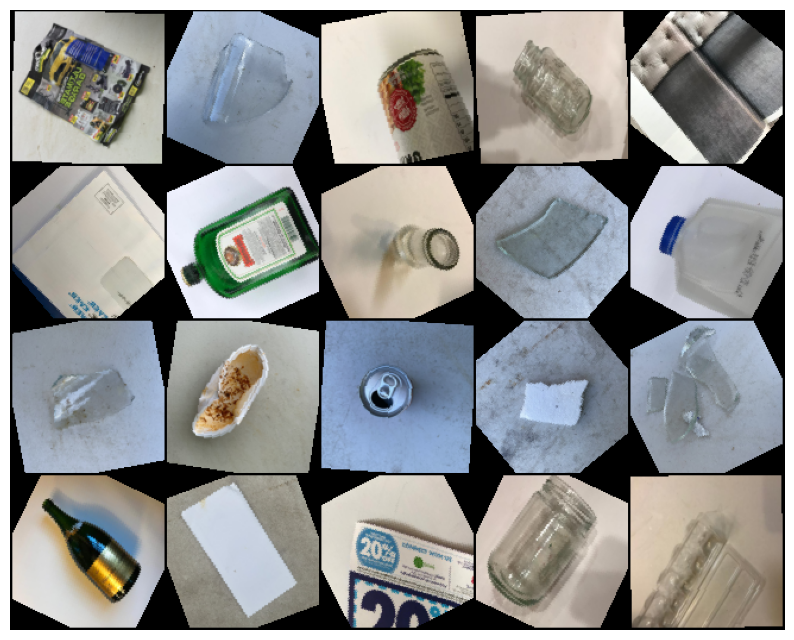

In [48]:
# Visualize a few sample images from the dataset 
train_loader_for_vis, _, _ = get_trash_data_loader(20, 128)

# Get a batch of training data
inputs, classes = next(iter(train_loader_for_vis))

# Make a 5x5 grid from the batch of images
out = torchvision.utils.make_grid(inputs, nrow=5)

plt.figure(figsize=(10,10))
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [49]:
class LargeNet256(nn.Module):
    def __init__(self):
        super(LargeNet256, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=10 * 30 * 30, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #convolution, relu activation, max pooling
        x = self.pool(F.relu(self.conv2(x))) #convolution, relu activation, max pooling
        x = x.view(-1, 10 * 30 * 30)
        x = F.relu(self.fc1(x)) #linear, relu activation
        x = self.fc2(x) #linear

        return x

In [50]:
class OptimizedCNN256(nn.Module):
    def __init__(self):
        super(OptimizedCNN256, self).__init__()
        
        # [input - kernel + 2*padding] / stride + 1

        # Conv #1
        # [3, 256, 256] -> [5, 252, 252]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=0)
        
        # MaxPooling
        # [5, 252, 252] -> [5, 126, 126]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv #2
        # [5, 126, 126] -> [10, 122, 122]
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=0)

        # After the first layer: (256 - 5 + 1) / 1 = 252, then pooled: 252 / 2 = 126
        # After the second layer: (126 - 5 + 1) / 1 = 122, then pooled: 122 / 2 = 61
        self.num_flat_features = 10 * 61 * 61

        # First fully connected layer
        self.fc1 = nn.Linear(self.num_flat_features, 120)

        # Second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # Output layer
        self.fc3 = nn.Linear(84, 4)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [51]:
class OptimizedCNN128(nn.Module):
    def __init__(self):
        super(OptimizedCNN128, self).__init__()
        
        # Conv #1: [3, 128, 128] -> [5, 124, 124]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=0)
        
        # MaxPooling: [5, 124, 124] -> [5, 62, 62]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv #2: [5, 62, 62] -> [10, 58, 58]
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Adjusted for input size of 128x128
        self.num_flat_features = 10 * 29 * 29  # 8410

        # First fully connected layer
        self.fc1 = nn.Linear(self.num_flat_features, 120)

        # Second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # Output layer
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [52]:
# 128x128 images
class LargeNet128(nn.Module):
    def __init__(self):
        super(LargeNet128, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=10 * 14 * 14, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 14 * 14) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [53]:
def plot_training_curve(config, train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation losses and accuracies."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [54]:
def train(model, train_loader, valid_loader, config):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    training_start_time = time.process_time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 

    best_valid_loss = float('inf')
    best_valid_acc = 0

    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

    for epoch in range(config['num_epochs']):
        start_of_epoch = time.process_time()
        
        model.train()  # Set model to training mode
        total_train_loss, total_train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = total_train_correct / (len(train_loader.dataset))
        train_accs.append(train_accuracy)

        # Set model to evaluation mode
        model.eval()
        total_valid_loss, total_valid_correct = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid_correct += (predicted == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_accuracy)

        # Update best validation loss and accuracy
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_valid_acc = valid_accuracy

        time_elapsed = time.process_time() - start_of_epoch
        print(f"Epoch {epoch+1}/{config['num_epochs']} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_valid_loss:.4f} | Train Acc: {train_accuracy:.4f} | Validation Acc: {valid_accuracy:.4f} | Time: {time_elapsed:.4f}")

    # Training curve plot
    plot_training_curve(config, train_losses, valid_losses, train_accs, valid_accs)

    time_elapsed = time.process_time() - training_start_time
    print(f"Training complete in {time_elapsed:.2f}s")
    return best_valid_loss, best_valid_acc

Training OptimizedCNN128 model with config: {'learning_rate': 0.001, 'num_epochs': 30, 'batch_size': 128}
Epoch 1/30 | Train Loss: 2.0423 | Validation Loss: 1.3684 | Train Acc: 0.2415 | Validation Acc: 0.3003 | Time: 0.9531
Epoch 2/30 | Train Loss: 1.3171 | Validation Loss: 1.2754 | Train Acc: 0.3572 | Validation Acc: 0.4352 | Time: 0.9375
Epoch 3/30 | Train Loss: 1.2478 | Validation Loss: 1.2673 | Train Acc: 0.4171 | Validation Acc: 0.4454 | Time: 1.0000
Epoch 4/30 | Train Loss: 1.2206 | Validation Loss: 1.2060 | Train Acc: 0.4341 | Validation Acc: 0.3771 | Time: 0.9219
Epoch 5/30 | Train Loss: 1.1993 | Validation Loss: 1.1893 | Train Acc: 0.4386 | Validation Acc: 0.4778 | Time: 0.9688
Epoch 6/30 | Train Loss: 1.1775 | Validation Loss: 1.1868 | Train Acc: 0.4540 | Validation Acc: 0.4778 | Time: 0.9062
Epoch 7/30 | Train Loss: 1.1590 | Validation Loss: 1.1793 | Train Acc: 0.4559 | Validation Acc: 0.4829 | Time: 0.9688
Epoch 8/30 | Train Loss: 1.1497 | Validation Loss: 1.1449 | Train Ac

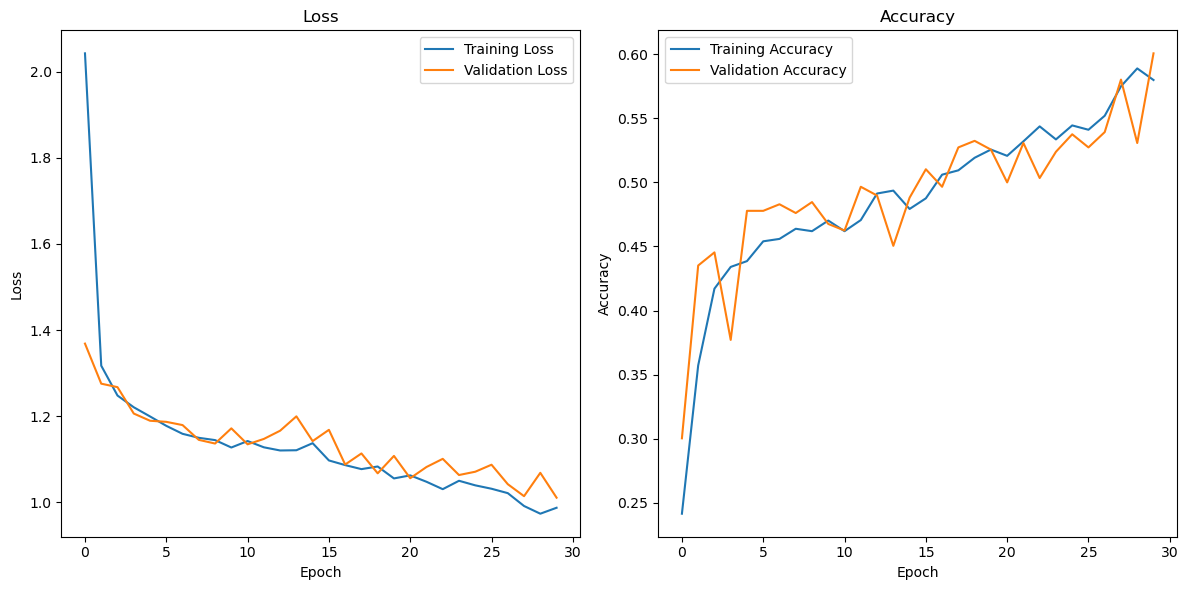

Training complete in 29.23s
Model saved to model_OptimizedLargeNet256_lr=0.001_epochs=30_batch=128.pth
Time elapsed: 29.34375
Best performing model configuration: {'learning_rate': 0.001, 'num_epochs': 30, 'batch_size': 128}
With Validation Loss: 1.010720694065094 and Validation Accuracy: 0.6006825938566553


In [55]:
hyperparameter_configs = [
    # {'learning_rate': 1e-3, 'num_epochs': 30, 'batch_size': 256},
    {'learning_rate': 1e-3, 'num_epochs': 30, 'batch_size': 128},
    # {'learning_rate': 1e-4, 'num_epochs': 30, 'batch_size': 64},
    # {'learning_rate': 1e-5, 'num_epochs': 30, 'batch_size': 64},
]

performance_tracking = []

for config in hyperparameter_configs:
    start = time.process_time()
    
    model = OptimizedCNN128().to(device)
    
    print(f"Training {model.__class__.__name__} model with config: {config}")

    train_loader, val_loader, test_loader = get_trash_data_loader(batch_size=config["batch_size"], img_dim=128)
    
    best_valid_loss, best_valid_acc = train(model, train_loader, val_loader, config)

    # Track the performance for each config
    performance_tracking.append({
        'config': config,
        'best_valid_acc': best_valid_acc,
        'best_valid_loss': best_valid_loss
    })

    # Save the model after training
    model_save_path = f"{path_to_project}model_{model.__class__.__name__}_lr={config['learning_rate']}_epochs={config['num_epochs']}_batch={config['batch_size']}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"Time elapsed: {time.process_time() - start}")

# Determine best performing model
best_performance = sorted(performance_tracking, key=lambda x: x['best_valid_loss'])[0]
print("Best performing model configuration:", best_performance['config'])
print("With Validation Loss:", best_performance['best_valid_loss'], "and Validation Accuracy:", best_performance['best_valid_acc'])

In [56]:
def load_model(model_class, model_path):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [57]:
def predict_image(image_path, model, device, img_dim=128):
    """Predict the class for a single image."""
    transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

In [66]:
from PIL import Image

model_path = f"{path_to_project}model_OptimizedLargeNet256_lr=0.001_epochs=30_batch=128.pth"
image_path = f"{path_to_project}split_data/test/Paper/Paper_8.jpg"

model = load_model(OptimizedCNN128, model_path)

predicted_class = predict_image(image_path, model, device)

# 0 = Glass, 1 = Metal, 2 = Paper, 3 = Plastic
print(f"Predicted class: {predicted_class}")

Predicted class: 2
